# Search for anomalies in the operation of a closed circuit of liquid circulation
### Поиск аномалий в работе замкнутого контура циркуляции жидкости

## Importing packages & modules
#### Импорт пакетов и модулей

In [1]:
import sys
# Add parent directory to sys.path to import tsad modules
sys.path.insert(1, '../')

# Import custom modules
from tsad.base.pipeline import Pipeline

## Data loading

#### Загрузка данных

In [2]:
# Import function for loading the dataset
# Импортируйте функцию для загрузки датасета
from tsad.base.datasets import load_skab

# Load the skab dataset in memory
# Загрузите набор данных skab в память
dataset = load_skab()

# Get the feature and target names from the dataset
# Получить имена признаков и целевых объектов из набора данных
columns = dataset.feature_names
targets = dataset.target_names

# Get the data frame from the dataset
# Получить фрейм данных из набора данных
df = dataset.frame

In [3]:
# Get the 0 level of the index of the dataframe
# Получаем уровень 0 индекса фрейма данных
df.index.levels[0]

Index(['air/0', 'air/1', 'fluid/0', 'fluid/1', 'fluid/2', 'fluid/3', 'fluid/4',
       'fluid/5', 'rotor/0', 'rotor/1', 'rotor/2', 'rotor/3', 'rotor/4',
       'temperature/0', 'valve1/0', 'valve1/1', 'valve1/10', 'valve1/11',
       'valve1/12', 'valve1/13', 'valve1/14', 'valve1/15', 'valve1/2',
       'valve1/3', 'valve1/4', 'valve1/5', 'valve1/6', 'valve1/7', 'valve1/8',
       'valve1/9', 'valve2/0', 'valve2/1', 'valve2/2', 'valve2/3'],
      dtype='object', name='experiment')

## Train Test Split
#### Разделение на выборки для обучения и теста

In [4]:
# Split the dataset into train and test sets (and we need to remove the labeling of the dataset for anomaly detection)
# Разделите набор данных на обучающий и тестовый наборы (и нужно удалить маркировку набора данных для обнаружения аномалий).
test_datasets = ['valve1/0', 'valve2/0', 'fluid/0']
train_raw = df.drop(test_datasets,level=0).droplevel(level=0).drop(columns=targets)
test_raw = df.loc[test_datasets].droplevel(level=0).drop(columns=targets)

In [5]:
train_raw.head(3)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.77031,0.382638,71.2129,25.0827,219.789,32.0000
2020-03-09 12:14:37,0.027269,0.040226,1.09696,0.710565,71.4284,25.0863,233.117,32.0104
2020-03-09 12:14:38,0.027040,0.039773,1.14015,0.054711,71.3468,25.0874,234.745,32.0000


## Creating and fitting pipeline
#### Создание и обучение конвейера

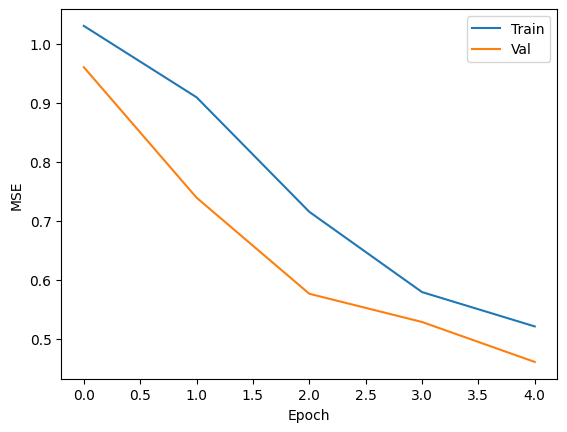

Epoch: 05 
	Train Loss: 0.521 
	 Val. Loss: 0.460 

Epoch: 04 
	Train Loss: 0.579 
	 Val. Loss: 0.528 

Epoch: 03 
	Train Loss: 0.715 
	 Val. Loss: 0.576 

Epoch: 02 
	Train Loss: 0.909 
	 Val. Loss: 0.739 

Epoch: 01 
	Train Loss: 1.030 
	 Val. Loss: 0.960 


After choosing the best model:
Test Loss: 1.298
asdasdas 4
(11707, 1, 8) (11707, 1, 8)


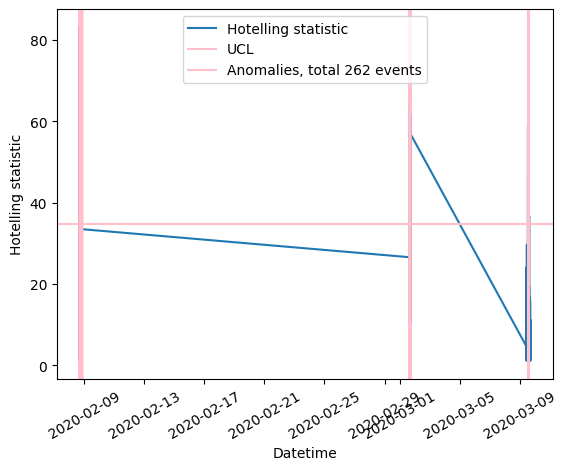

In [6]:
# Create a pipeline for multivariate time series deep learning forecasting with task set
# Создайте конвейер для многомерного прогнозирования с глубоким обучением временных рядов с предопределенным набором задач
from tsad.pipelines import ResidualAnomalyDetectionTaskSet
simple_pipeline = Pipeline(ResidualAnomalyDetectionTaskSet)

# Fit the pipeline on the train set
# Обучите конвейер на тестовом наборе данных
y_pred_train = simple_pipeline.fit_predict(train_raw)

## Inference of pipeline
#### Применение обученного конвейера

Skipped 5 datasets because the number of samples is too small in the dataset. (len_seq + points_ahead + gap -1 <= len(df))
(1348, 1, 8) (1348, 1, 8)


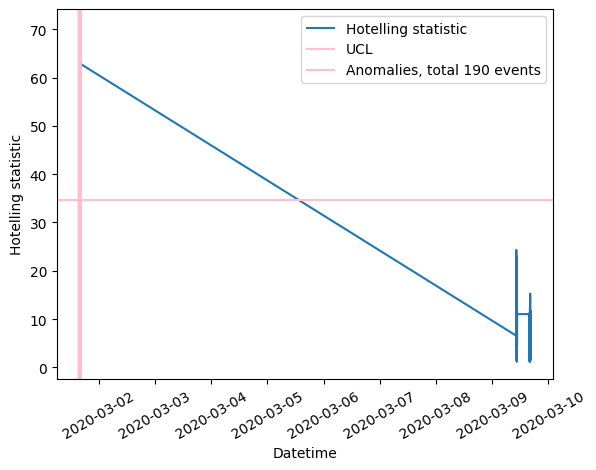

In [7]:
# Create prediction on test data
# Создание прогноза на основе тестовых данных
y_pred_test = simple_pipeline.predict(test_raw)

y_pred = y_pred_test.set_index(0)
y_pred['fact'] = 1
y_pred = y_pred['fact']

## Getting true labelling
#### Получение истинной маркировки

In [8]:
true  = df.loc[test_datasets].droplevel(level=0)['changepoint']
true = true.reset_index().drop_duplicates().set_index('datetime')['changepoint'].sort_index()

## Comparing results
#### Сравнение результатов

In [9]:
from tsad.utils.evaluating.evaluating import evaluating

In [10]:
evaluating(true = true, 
           prediction=y_pred,
           metric='nab', 
           window_width='30min',
           anomaly_window_destination = 'center',
       )

Standard  -  9.5
LowFP  -  9.45
LowFN  -  9.67


{'Standard': 9.5, 'LowFP': 9.45, 'LowFN': 9.67}